In [52]:
import numpy as np
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from kmodes.util.dissim import euclidean_dissim, matching_dissim
import os 
os.getcwd()
os.chdir('/home/jecosine/Courses/Courses/COMP8800/Projects/CatBoostPlayground')
import numpy as np
from sklearn.metrics import pairwise_distances, f1_score, accuracy_score
from sklearn.metrics import silhouette_score, silhouette_samples
from allib.metrics.distance import AVAIL_DIST_METRICS, get_dist_metric
from allib.datasets import load_uci
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
#if you want to know current working dir

# os.listdir()

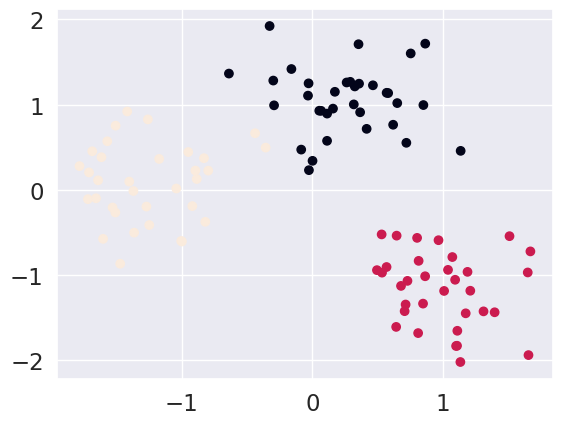

In [145]:
# make 3 clusters


data, label = make_blobs(100, 2, centers=3, random_state=0, cluster_std=0.6)
# normalize the data
data[:, 0] = (data[:, 0] - data[:, 0].mean()) / data[:, 0].std()
data[:, 1] = (data[:, 1] - data[:, 1].mean()) / data[:, 1].std() 

plt.scatter(data[:, 0], data[:, 1], c=label)

In [28]:
for i, X in enumerate(data):
    if X.dtype != np.float64:
        print(i, X.dtype)

In [148]:
# standard KModes
def euclidean(a, b, **_):
    """Euclidean distance dissimilarity function"""
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    return np.linalg.norm(a - b, axis=1)

km = KModes(n_clusters=3, max_iter=100, init='random', n_init=5, random_state=0, verbose=0, cat_dissim=euclidean)
km.labels_
# clusters = km.fit_predict(data)
# plt.scatter(data[:, 0], data[:, 1], c=clusters)
# plt.scatter(km.cluster_centroids_[:, 0], km.cluster_centroids_[:, 1], c='red', s=100)
# print(km.cluster_centroids_)

AttributeError: 'KModes' object has no attribute 'labels_'

In [3]:
def load_distance(dsn: str, mn: str, suffix = "catonly"):
    fn = f"examples/dist_cache_1000/{dsn}/{mn}_{suffix}.npy"
    return np.load(fn)

In [81]:
# index based KModes
# fdata, flabel = make_blobs(100, 2, centers=3, random_state=0, cluster_std=1)
ds = load_uci("heart-disease")

ds.with_preprocess(
    steps=[
        "sample_n", 
        "categorical_only",
        "remove_constant_columns", 
        "drop_duplicate_rows"
    ],  
    params_list=[
        {"n": 1000, "random_state": 0},
        {},
        {}, 
        {}
    ], 
    in_place=True
)
for col in ds._data.columns:
    ds._data[col] = ds._data[col].astype("category").cat.codes.astype(np.int64)


d = pairwise_distances(ds._data, metric="euclidean")

def dissim(a, b, **_):
    a = a.astype(np.int64)
    b = b.astype(np.int64)
    return d[a, b]

km = KModes(n_clusters=49, max_iter=100, init="random", random_state=0, verbose=0, cat_dissim=dissim)

clusters = km.fit_predict(np.arange(len(ds.u_x), dtype=int).reshape(-1, 1))

# plt.scatter(fdata[:, 0], fdata[:, 1], c=clusters)
# # # Print the cluster centroids
# plt.scatter(fdata[km.cluster_centroids_[:], 0], fdata[km.cluster_centroids_[:], 1], c='red', s=100)
print(len(km.cluster_centroids_), len(np.unique(clusters)))


49 48


In [67]:
len(km.cluster_centroids_)

90

In [89]:
ds = load_uci("adult")
# ds.with_preprocess(steps=["sample_n", "categorical_only", "remove_constant_columns", "drop_duplicate_rows"],  params_list=[{"n": 1000, "random_state": 0}, {}, {}, {}], in_place=True)
cat = ds.info["cat_idx"]
print(ds._data.shape[1])
ds.with_preprocess(
    steps=[
        "sample_n", 
        "categorical_only",
        # "continuous_to_categorical",
        "remove_constant_columns", 
        "drop_duplicate_rows"
    ],  
    params_list=[
        {"n": 1000, "random_state": 0},
        # {"encode": "ordinal"},
        {},
        {}, 
        {}
    ], 
    in_place=True
)

for col in ds._data.columns:
    if ds._data[col].dtype.name == "category":
        ds._data[col] = ds._data[col].astype("category").cat.codes

# convert string label to int label
label = ds._label.label.astype("category").cat.codes


14


In [31]:
ds._data.shape[0]

1000

In [ ]:
(0.8797250859106529, 0.7859327217125383), (0.8432432432432432, 0.7339449541284404)
(0.843488649940263, 0.7301750772399588), (0.8432432432432432, 0.7339449541284404)

In [121]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
adjusted_rand_score([0,1,1], [1,0,0])
normalized_mutual_info_score([0,1,1], [1,0,0])

1.0

In [134]:
new_res = {}
for m in AVAIL_DIST_METRICS:
    d = load_distance("adult", m, "catonly_wo_n")
    # uniform d
    # d = (d - d.min()) / (d.max() - d.min())
    d[d < 0] = 0
    np.fill_diagonal(d, 0)
    def dissim(a, b, **_):
        return d[a, b]
    km = KModes(n_clusters=2, max_iter=100, init="random", random_state=0, verbose=0, cat_dissim=dissim)
    clusters = km.fit_predict(np.arange(ds._data.shape[0], dtype=int).reshape(-1, 1))
    # new_res[m] = (f1_score(label, clusters, average="macro"), accuracy_score(label, clusters))
    new_res[m] = (silhouette_score(d, clusters, metric="precomputed"), adjusted_rand_score(label, clusters), normalized_mutual_info_score(label, clusters))

In [132]:
np.random.seed(0)
d = np.random.uniform(0, 1.0, (654, 654))
np.fill_diagonal(d, 0)
print(d.shape)
def dissim(a, b, **_):
    return d[a, b]
km = KModes(n_clusters=2, max_iter=100, init="random", random_state=0, verbose=0, cat_dissim=dissim)
clusters = km.fit_predict(np.arange(654, dtype=int).reshape(-1, 1))
new_res["random"] = (silhouette_score(d, clusters, metric="precomputed"), adjusted_rand_score(label, clusters), normalized_mutual_info_score(label, clusters))

(654, 654)


In [128]:
accuracy_score(label, [1]*len(label))

0.21253822629969418

In [135]:
for i in new_res:
    print(i, new_res[i])

euclidean (0.1438848547821755, 0.048913490378022034, 0.008030030751897255)
cosine (0.91746141329977, 0.0008523419100236056, 6.571013643763209e-06)
hamming (0.17749843122403738, 0.1501908736144846, 0.11331481727911502)
overlap (0.17749843122403738, 0.1501908736144846, 0.11331481727911502)
eskin (0.7387065050166971, -0.016151672973151347, 0.026691550025186847)
iof (0.18259389866107584, 0.14650352742057648, 0.11383622063582216)
of (0.10964752678957365, 0.027583468648777747, 0.07257340260433283)
lin (0.13157590941695843, 0.11885590476545867, 0.10474341380267736)
lin1 (0.10503950247019317, -0.03760241015346482, 0.017350551106283838)
goodall1 (0.09209600233976528, 0.055926783857176345, 0.07240637062122886)
goodall2 (0.14267585814282188, 0.055926783857176345, 0.07240637062122886)
goodall3 (0.11608661550402491, 0.08209169656715203, 0.08122665609869353)
goodall4 (0.0983874319197948, 0.1253006382133071, 0.1277752898075934)
smirnov (0.002395436290072007, 0.04481904609204313, 0.0619197167179936)
g

In [101]:
for i in res:
    print(i, res[i])

euclidean (0.44857449088960344, 0.5489296636085627)
cosine (0.4283462033462033, 0.5015290519877675)
hamming (0.45792702414080705, 0.5122324159021406)
overlap (0.318997086731172, 0.3195718654434251)
eskin (0.4017064037540882, 0.40978593272171254)
iof (0.3142086735076024, 0.3149847094801223)
of (0.31186997980177555, 0.3149847094801223)
lin (0.3347363990318847, 0.3348623853211009)
lin1 (0.5003581148832545, 0.7064220183486238)
goodall1 (0.373310160176617, 0.3761467889908257)
goodall2 (0.31857613482840896, 0.3195718654434251)
goodall3 (0.37215017545506823, 0.3746177370030581)
goodall4 (0.46403205244946283, 0.7798165137614679)
smirnov (0.41841729184691057, 0.43577981651376146)
gambaryan (0.47463216641298833, 0.5351681957186545)
burnaby (0.3017984725301799, 0.30428134556574926)
anderberg (0.3119266055045872, 0.3119266055045872)
random (0.47701121347777237, 0.5244648318042814)


In [91]:
km = KMeans(n_clusters=2, random_state=0, n_init=10)

clusters = km.fit_predict(ds._data)
f1_score(label, clusters, average="macro"), accuracy_score(label, clusters)

(0.4822276822276822, 0.7339449541284404)

In [50]:
ds._data.shape[1]

12

In [48]:
ed = load_distance("adult", "euclidean")
def eu(a, b, **_):
    # calculate goodall4 distance
    return ed[a, b]

kp = KPrototypes(n_clusters=2, max_iter=100, init="random", random_state=0, verbose=0, num_dissim=eu,cat_dissim=dissim)
clusters = kp.fit_predict(ds._data, categorical=cat)
f1_score(label, clusters, pos_label=0), accuracy_score(label, clusters)

AssertionError: Categorical index larger than number of columns.

In [143]:
candidates = ["euclidean", "cosine", "hamming", "smirnov", "goodall1", "iof", "anderberg", "gambaryan"]
res = {}
samples = {}
for dn in candidates:
    d = load_distance("adult", dn, "catonly_wo_n")
    np.fill_diagonal(d, 0)
    print(np.var(d.flatten()/d.max()), np.max(d.flatten()), np.min(d.flatten()))
    # def dissim(a, b, **_):
    #     return d[a, b]

    # km = KModes(n_clusters=2, max_iter=100, init='random', n_init=10, random_state=0, verbose=0, cat_dissim=dissim)

    # clusters = km.fit_predict(np.arange(d.shape[0]).reshape(-1, 1))
    # # f1 score
    # print(f1_score(label, clusters, pos_label=1))
    res[dn] = silhouette_score(d, label, metric="precomputed", random_state=0)
    samples[dn] = silhouette_samples(d, label, metric="precomputed", random_state=0)

0.049462516591649845 44.44097208657794 0.0
0.033131772862489535 0.9934110099154956 0.0
0.02981727586963549 1.0 0.0
0.0015468599520735153 15.568575481193282 0.0
0.016678181358923044 0.9392822353662933 0.0
0.028877624100357213 0.9606193329901543 0.0
0.05868044052105335 1.0 0.0
0.014363792960848446 0.0213279555938536 0.0


In [138]:
def new_metric(s, label):
    return np.mean(s[label == 0]),np.mean(s[label == 1])

for dn in candidates:
    print(dn, new_metric(samples[dn], label))

# silhouette_score(fdata, flabel, metric="euclidean", random_state=0)

euclidean (-0.04901291689294851, 0.07007214140240395)
cosine (-0.009503610703264326, 0.022470495848137227)
hamming (0.0241633968693884, 0.148583541432224)
smirnov (-0.10202403951202328, -0.248134445750335)
goodall1 (-0.12014333589657405, -0.2265875231994567)
iof (-0.06275505665023119, -0.17847585135992547)
anderberg (-0.11601613413054722, -0.23108223861436641)
gambaryan (-0.09999403572896566, -0.16136933067940123)


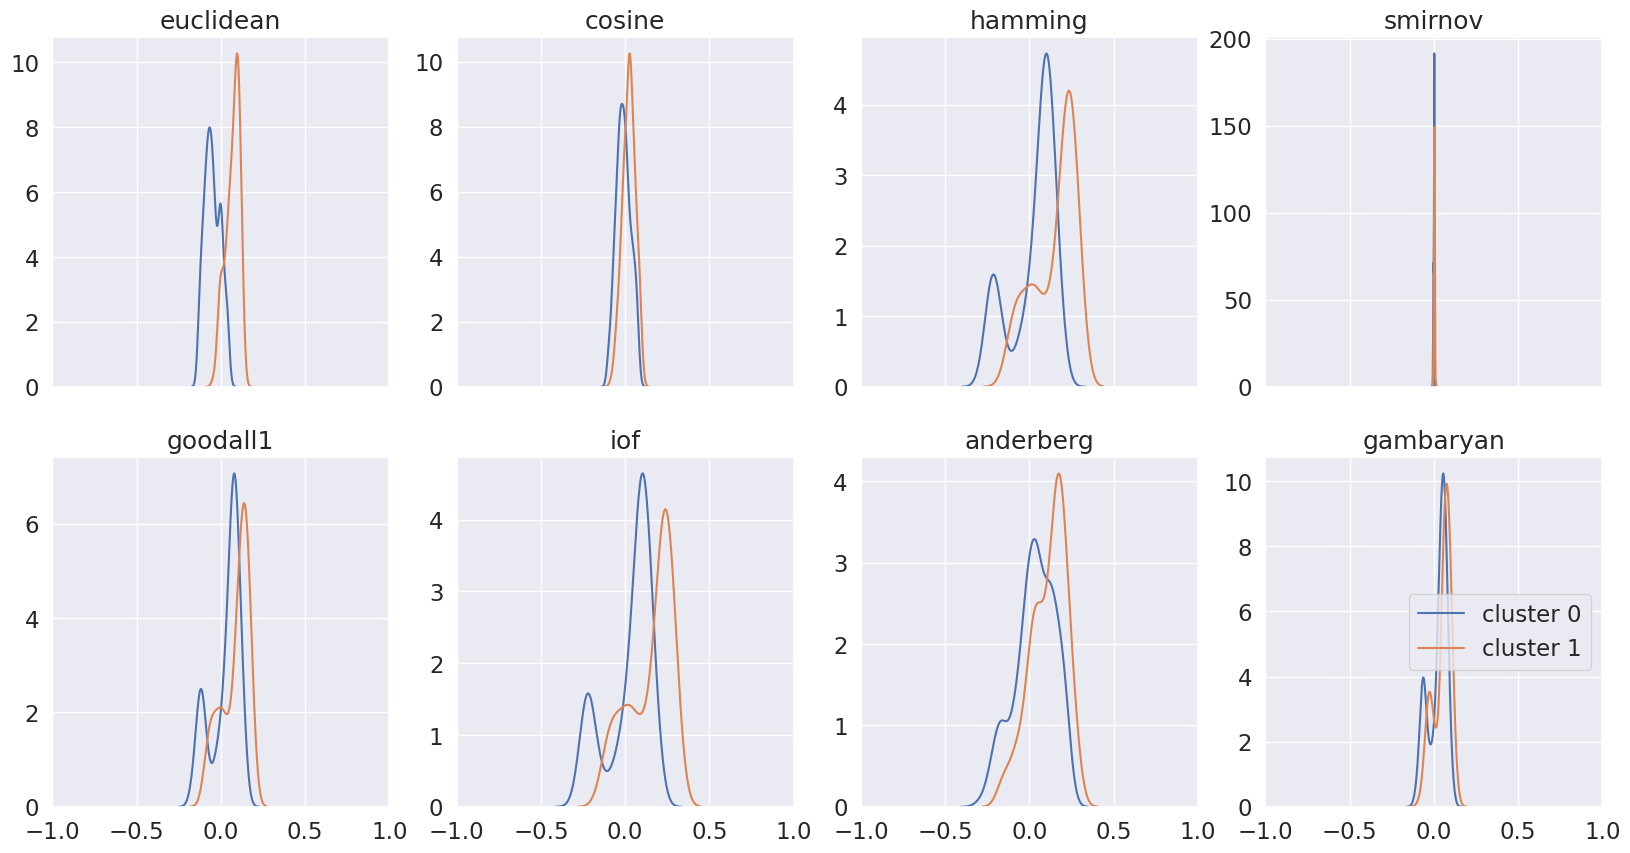

In [144]:
import seaborn as sns
dn = ["euclidean", "cosine", "hamming", "smirnov", "goodall1", "iof", "anderberg", "gambaryan"]
sns.set(font_scale=1.5)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.patch.set_alpha(0)
for i, ax in enumerate(axs.flatten()):
    ax.set_title(dn[i])
    sns.kdeplot(samples[dn[i]][label == 0], label="cluster 0", ax=ax)
    sns.kdeplot(samples[dn[i]][label == 1], label="cluster 1", ax=ax)
    ax.set_xlim(-1, 1)
    # ax.set_yticks([])
    if i < 4:
        ax.set_xticks(np.arange(-1, 1.5, 0.5), [""] * 5)
    # ax.set_xlabel("Silhouette score")
    ax.set_ylabel("")
ax.legend()
# sns.kdeplot(samples["euclidean"][label == 0], label="0")
# sns.kdeplot(samples["euclidean"][label == 1], label="1")